<a href="https://colab.research.google.com/github/ysoniwal/statistics/blob/main/01_matrix_factorization_for_recommender_systems_movie_lens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Read and preprocess the data

In [1]:
!nvidia-smi 

Sat Aug 20 15:59:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip '/content/drive/MyDrive/Colab Notebooks/datasets/rating.csv.zip'

Archive:  /content/drive/MyDrive/Colab Notebooks/datasets/rating.csv.zip
  inflating: rating.csv              
   creating: __MACOSX/
  inflating: __MACOSX/._rating.csv   


In [5]:
!unzip '/content/drive/MyDrive/Colab Notebooks/datasets/movie.csv.zip'

Archive:  /content/drive/MyDrive/Colab Notebooks/datasets/movie.csv.zip
  inflating: movie.csv               
  inflating: __MACOSX/._movie.csv    


In [6]:
ratings_df = pd.read_csv('rating.csv')

In [7]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [8]:
ratings_df['userId'].nunique(), len(ratings_df)

(138493, 20000263)

In [9]:
ratings_df['userId'].min(), ratings_df['userId'].max()

(1, 138493)

In [10]:
ratings_df['movieId'].min(), ratings_df['movieId'].max(), ratings_df['movieId'].nunique(),

(1, 131262, 26744)

### Preprocess the ratings CSV file 
1. Starts user ids to go from 0
2. Movie ids range from 1 to 131k, but there are only 26k unique movie ids -> So create a mapping from 
    movie id to num and add movie_idx column to the dataframe
3. Delete timestamp column

In [11]:
ratings_df.userId = ratings_df.userId - 1

In [12]:
unique_movie_ids = set(ratings_df.movieId.values)
movie2Idx = {}
count = 0
for movie_id in unique_movie_ids:
  movie2Idx[movie_id] = count
  count += 1

In [13]:
ratings_df['movie_idx'] = ratings_df.apply(lambda row: movie2Idx[row.movieId], axis=1)

### Create a subset of users and movies to work with

In [14]:
N = ratings_df.userId.max() + 1 # number of users
M = ratings_df.movie_idx.max() + 1 # number of movies

N, M

(138493, 26744)

In [15]:
from collections import Counter

user_ids_count = Counter(ratings_df.userId)
movie_ids_count = Counter(ratings_df.movie_idx)

In [16]:
# number of users and movies we would like to keep
n = 10000
m = 2000

In [17]:
# Find most common users and movies
user_ids = [u for u, c in user_ids_count.most_common(n)]
movie_ids = [m for m, c in movie_ids_count.most_common(m)]

In [18]:
# make a copy, otherwise ids won't be overwritten
df_small = ratings_df[ratings_df.userId.isin(user_ids) & ratings_df.movie_idx.isin(movie_ids)].copy()

In [19]:
# need to remake user ids and movie ids since they are no longer sequential
new_user_id_map = {}
i = 0
for old in user_ids:
  new_user_id_map[old] = i
  i += 1
print("i:", i)

new_movie_id_map = {}
j = 0
for old in movie_ids:
  new_movie_id_map[old] = j
  j += 1
print("j:", j)

i: 10000
j: 2000


In [20]:
print("Setting new ids")
df_small.loc[:, 'userId'] = df_small.apply(lambda row: new_user_id_map[row.userId], axis=1)
df_small.loc[:, 'movie_idx'] = df_small.apply(lambda row: new_movie_id_map[row.movie_idx], axis=1)
# df_small.drop(columns=['userId', 'movie_idx'])
# df_small.rename(index=str, columns={'new_userId': 'userId', 'new_movie_idx': 'movie_idx'})
print("max user id:", df_small.userId.max())
print("max movie id:", df_small.movie_idx.max())

print("small dataframe size:", len(df_small))
df_small.to_csv('/content/drive/MyDrive/Colab Notebooks/datasets/small_rating.csv', index=False)

Setting new ids
max user id: 9999
max movie id: 1999
small dataframe size: 5392025


### Create Very Small DF


In [21]:
# number of users and movies we would like to keep
n = 1000
m = 200

# Find most common users and movies
user_ids = [u for u, c in user_ids_count.most_common(n)]
movie_ids = [m for m, c in movie_ids_count.most_common(m)]

# make a copy, otherwise ids won't be overwritten
df_very_small = ratings_df[ratings_df.userId.isin(user_ids) & ratings_df.movie_idx.isin(movie_ids)].copy()

# need to remake user ids and movie ids since they are no longer sequential
new_user_id_map = {}
i = 0
for old in user_ids:
  new_user_id_map[old] = i
  i += 1
print("i:", i)

new_movie_id_map = {}
j = 0
for old in movie_ids:
  new_movie_id_map[old] = j
  j += 1
print("j:", j)

print("Setting new ids")
df_very_small.loc[:, 'userId'] = df_very_small.apply(lambda row: new_user_id_map[row.userId], axis=1)
df_very_small.loc[:, 'movie_idx'] = df_very_small.apply(lambda row: new_movie_id_map[row.movie_idx], axis=1)
# df_small.drop(columns=['userId', 'movie_idx'])
# df_small.rename(index=str, columns={'new_userId': 'userId', 'new_movie_idx': 'movie_idx'})
print("max user id:", df_very_small.userId.max())
print("max movie id:", df_very_small.movie_idx.max())

print("very small dataframe size:", len(df_very_small))
df_small.to_csv('/content/drive/MyDrive/Colab Notebooks/datasets/very_small_rating.csv', index=False)

i: 1000
j: 200
Setting new ids
max user id: 999
max movie id: 199
very small dataframe size: 167035


In [22]:
del ratings_df
del df_small
del df_very_small

In [23]:
# load in the data
# https://www.kaggle.com/grouplens/movielens-20m-dataset

from sklearn.utils import shuffle

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/very_small_rating.csv')

N = df.userId.max() + 1 # number of users
M = df.movie_idx.max() + 1 # number of movies

# split into train and test
df = shuffle(df)
cutoff = int(0.8*len(df))
df_train = df.iloc[:cutoff]
df_test = df.iloc[cutoff:]

In [24]:
# a dictionary to tell us which users have rated which movies
user2movie = {}
# a dicationary to tell us which movies have been rated by which users
movie2user = {}
# a dictionary to look up ratings
usermovie2rating = {}
print("Calling: update_user2movie_and_movie2user")
count = 0
def update_user2movie_and_movie2user(row):
  global count
  count += 1
  if count % 100000 == 0:
    print("processed: %.3f" % (float(count)/cutoff))

  i = int(row.userId)
  j = int(row.movie_idx)
  if i not in user2movie:
    user2movie[i] = [j]
  else:
    user2movie[i].append(j)

  if j not in movie2user:
    movie2user[j] = [i]
  else:
    movie2user[j].append(i)

  usermovie2rating[(i,j)] = row.rating
  
df_train.apply(update_user2movie_and_movie2user, axis=1)

Calling: update_user2movie_and_movie2user
processed: 0.023
processed: 0.046
processed: 0.070
processed: 0.093
processed: 0.116
processed: 0.139
processed: 0.162
processed: 0.185
processed: 0.209
processed: 0.232
processed: 0.255
processed: 0.278
processed: 0.301
processed: 0.325
processed: 0.348
processed: 0.371
processed: 0.394
processed: 0.417
processed: 0.440
processed: 0.464
processed: 0.487
processed: 0.510
processed: 0.533
processed: 0.556
processed: 0.580
processed: 0.603
processed: 0.626
processed: 0.649
processed: 0.672
processed: 0.695
processed: 0.719
processed: 0.742
processed: 0.765
processed: 0.788
processed: 0.811
processed: 0.835
processed: 0.858
processed: 0.881
processed: 0.904
processed: 0.927
processed: 0.950
processed: 0.974
processed: 0.997


3058148    None
1153568    None
4455943    None
5123900    None
737173     None
           ... 
4843959    None
5265922    None
2235265    None
1663938    None
120076     None
Length: 4313620, dtype: object

In [25]:
# test ratings dictionary
usermovie2rating_test = {}
print("Calling: update_usermovie2rating_test")
count = 0
def update_usermovie2rating_test(row):
  global count
  count += 1
  if count % 100000 == 0:
    print("processed: %.3f" % (float(count)/len(df_test)))

  i = int(row.userId)
  j = int(row.movie_idx)
  usermovie2rating_test[(i,j)] = row.rating
df_test.apply(update_usermovie2rating_test, axis=1)

Calling: update_usermovie2rating_test
processed: 0.093
processed: 0.185
processed: 0.278
processed: 0.371
processed: 0.464
processed: 0.556
processed: 0.649
processed: 0.742
processed: 0.835
processed: 0.927


115361     None
1231734    None
3525280    None
3272988    None
2551175    None
           ... 
2967441    None
1566847    None
3992560    None
652134     None
2934334    None
Length: 1078405, dtype: object

In [26]:
# note: these are not really JSONs
import pickle

with open('user2movie.json', 'wb') as f:
  pickle.dump(user2movie, f)

with open('movie2user.json', 'wb') as f:
  pickle.dump(movie2user, f)

with open('usermovie2rating.json', 'wb') as f:
  pickle.dump(usermovie2rating, f)

with open('usermovie2rating_test.json', 'wb') as f:
  pickle.dump(usermovie2rating_test, f)

## Model1: Matrix Factorization in Tensorflow

In [35]:
df_train.head()

,userId,movieId,rating,timestamp,movie_idx
3058148,1802,6934,2.5,2003-12-02 23:57:10,350
1153568,2580,924,4.0,2005-03-04 01:41:02,90
4455943,3530,68791,3.0,2009-06-23 19:27:16,1954
5123900,44,2701,2.0,2006-01-12 17:30:25,408
737173,984,4558,3.0,2007-03-09 03:21:03,1548


In [36]:
df_test.head()

,userId,movieId,rating,timestamp,movie_idx
115361,1976,1747,5.0,2005-10-25 00:16:44,426
1231734,2573,3977,5.0,2001-07-30 19:10:20,220
3525280,4005,2243,5.0,2000-03-07 10:30:16,847
3272988,804,33493,3.5,2005-06-06 12:35:21,348
2551175,8482,2529,4.0,2000-08-05 02:45:55,332


In [37]:
df_train.shape, df_test.shape

((4313620, 5), (1078405, 5))

In [38]:
## Global variables
K = 10 # Latent dimension
mu = df_train.rating.mean()
EPOCHS = 5
REG = 0 # Regularization

N = 1000
M = 200

In [39]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten, Dense, Concatenate
from tensorflow.keras.regularizers import L2

In [40]:
N, M

(1000, 200)

In [43]:
import tensorflow as tf

u = tf.keras.Input(shape=(1,), name = "user_id_input")
m = tf.keras.Input(shape=(1,), name = "movie_id_input")

emb_u = Embedding(input_dim = N,
                  output_dim = K,
                  embeddings_regularizer = L2(l2 = REG),
                  name = "user_id_embedding")(u)
emb_m = Embedding(input_dim = M,
                  output_dim = K,
                  embeddings_regularizer = L2(l2 = REG),
                  name = "movie_id_embedding")(m)

user_bias = Embedding(input_dim = N,
                      output_dim = 1,
                      embeddings_regularizer = L2(l2 = REG),
                      name = "user_bias_embedding")(u)

movie_bias = Embedding(input_dim = M,
                       output_dim = 1,
                       embeddings_regularizer = L2(l2 = REG),
                       name = "movie_bias_embedding")(m)

x = Dot(axes = 2, name = "dot_user_movie_embeddings")([emb_u, emb_m])

x = Add(name = "add_dot__user_bias__movie_bias")([x, user_bias, movie_bias])
x = Flatten()(x)

model_1 = tf.keras.Model(inputs = [u, m], outputs = x, name = "matrix_factorization_model")
model_1.summary()

Model: "matrix_factorization_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_id_input (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 movie_id_input (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 user_id_embedding (Embedding)  (None, 1, 10)        10000       ['user_id_input[0][0]']          
                                                                                                  
 movie_id_embedding (Embedding)  (None, 1, 10)       2000        ['movie_id_input[0][0]']         
                                                                         

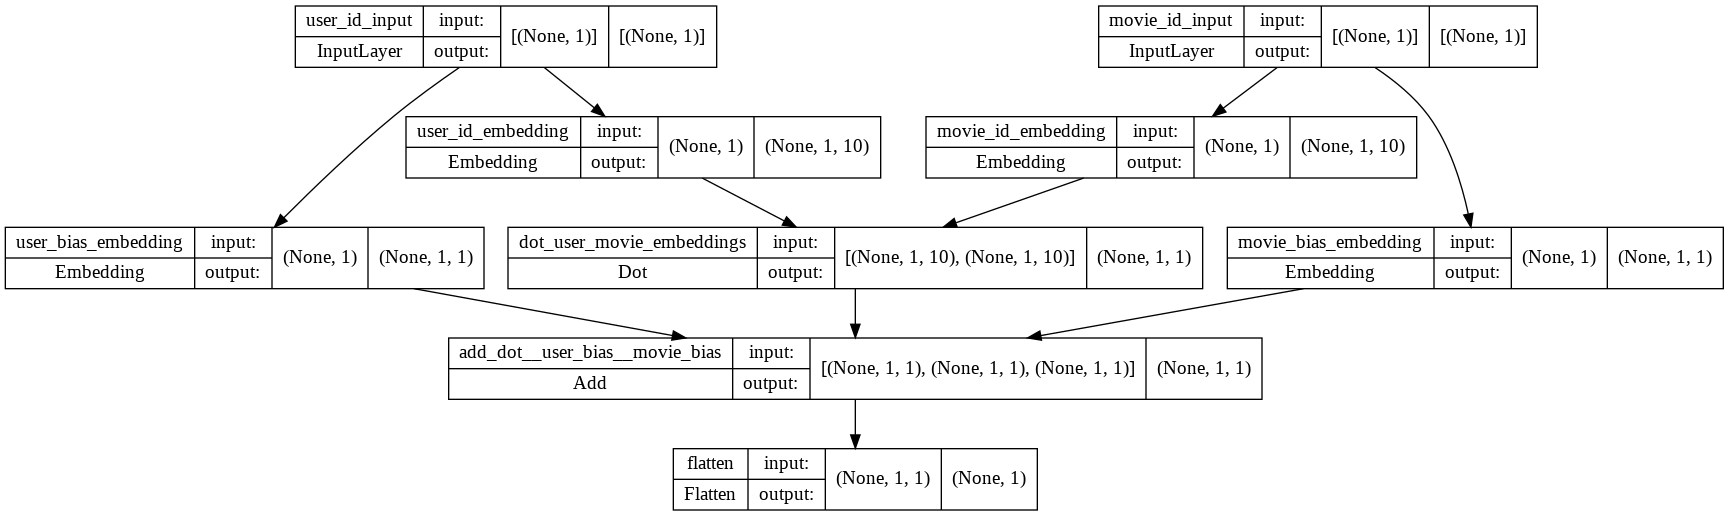

In [44]:
tf.keras.utils.plot_model(model_1, show_shapes=True)

```
Input1 -> user_id -> An integer -> Embedding to K dim
Input2 -> movie_id -> An integer -> Embedding to K dim
user_bias -> Input user_id -> An integer -> Embedding to 1 dim
movie_bias -> Input movie_id -> An integer -> Embedding to 1 dim

dot(Embedding1, Embedding2) over last axis (i.e. axis with K length) + user_bias_embedding + movie_bias_embedding

Then flatten this -> This is output
```

In [45]:
model_1.compile(
    loss = 'mse',
    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9),
    metrics = ['mse']
)

history_1 = model_1.fit(
    x = [df_train.userId.values, df_train.movie_idx.values],
    y = df_train.rating.values - mu,
    epochs = EPOCHS,
    batch_size = 128,
    validation_data = (
        [df_test.userId.values, df_test.movie_idx.values],
        df_test.rating.values - mu
    )
)

Epoch 1/5
33701/33701 [==============================] - 105s 3ms/step - loss: 0.9649 - mse: 0.9649 - val_loss: 0.9536 - val_mse: 0.9536
Epoch 2/5
33701/33701 [==============================] - 102s 3ms/step - loss: 0.9508 - mse: 0.9508 - val_loss: 0.9510 - val_mse: 0.9510
Epoch 3/5
33701/33701 [==============================] - 108s 3ms/step - loss: 0.9497 - mse: 0.9497 - val_loss: 0.9507 - val_mse: 0.9507
Epoch 4/5
33701/33701 [==============================] - 111s 3ms/step - loss: 0.9496 - mse: 0.9496 - val_loss: 0.9506 - val_mse: 0.9506
Epoch 5/5
33701/33701 [==============================] - 107s 3ms/step - loss: 0.9496 - mse: 0.9496 - val_loss: 0.9506 - val_mse: 0.9506


In [46]:
results_1 = model_1.evaluate([df_test.userId.values, df_test.movie_idx.values], df_test.rating.values - mu)
results_1

33701/33701 [==============================] - 65s 2ms/step - loss: 0.9506 - mse: 0.9506


[0.9505849480628967, 0.9505849480628967]

In [47]:
history_1.history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

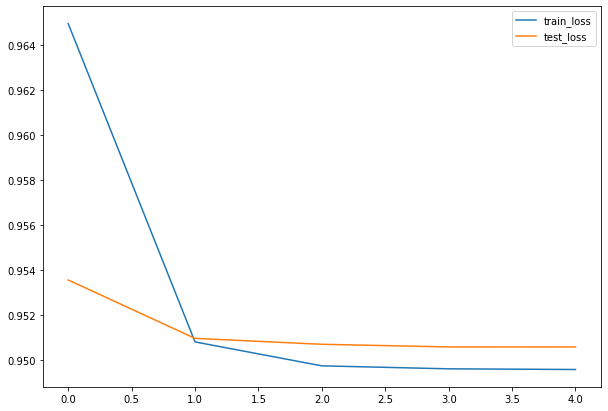

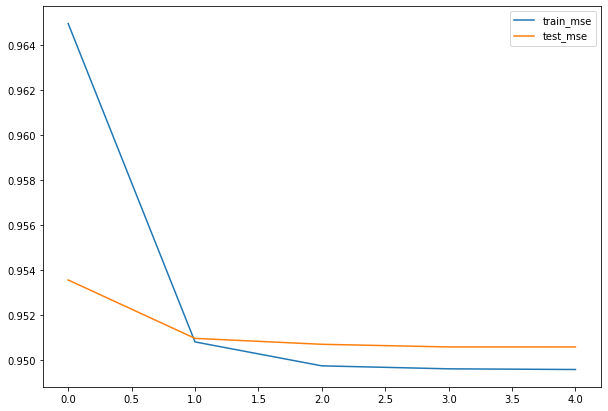

In [48]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.plot(history_1.history['loss'], label = 'train_loss')
plt.plot(history_1.history['val_loss'], label = 'test_loss')
plt.legend()

plt.figure(figsize=(10, 7))
plt.plot(history_1.history['mse'], label = 'train_mse')
plt.plot(history_1.history['val_mse'], label = 'test_mse')
plt.legend()
plt.show();

## Model 2: Dense Model - Concat(Embeddings) as input to dense model

In [57]:
# Since working only with df_train and df_test, deleting df
del df

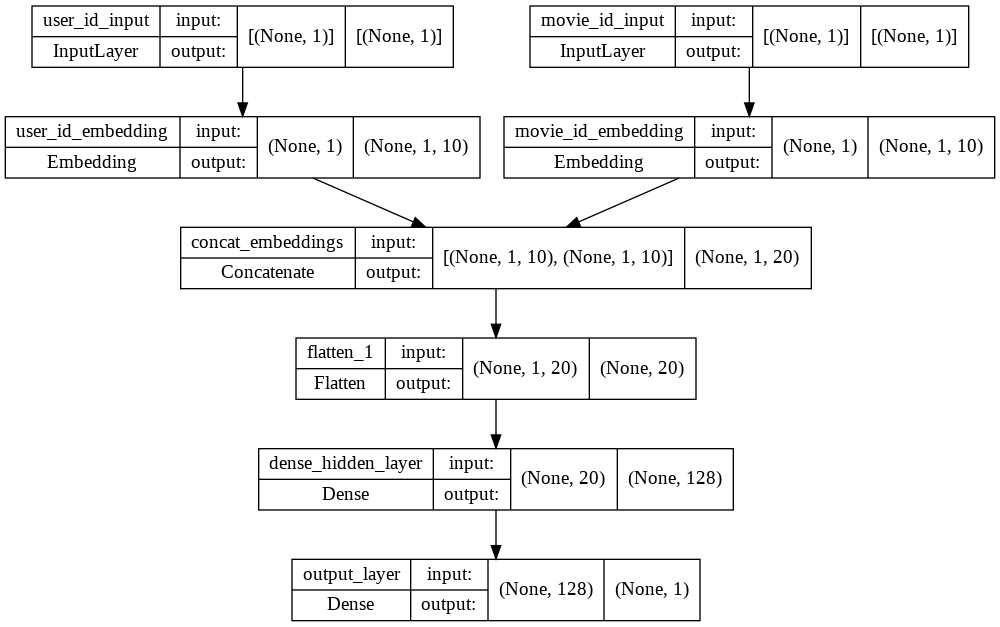

In [58]:
u = tf.keras.Input(shape=(1,), name = "user_id_input")
m = tf.keras.Input(shape=(1,), name = "movie_id_input")

emb_u = Embedding(input_dim = N,
                  output_dim = K,
                  embeddings_regularizer = L2(l2=REG),
                  name = "user_id_embedding")(u)
emb_m = Embedding(input_dim = M,
                  output_dim = K,
                  embeddings_regularizer = L2(l2=REG),
                  name = "movie_id_embedding")(m)

## Concatenate User and Movie ID embeddings
x = Concatenate(name = "concat_embeddings")([emb_u, emb_m])
x = Flatten()(x)
x = Dense(units = 128, activation = 'relu', name = "dense_hidden_layer")(x)
outputs = Dense(units = 1, activation = None, name = "output_layer")(x)

model_2 = tf.keras.Model(inputs = [u, m], 
                         outputs = outputs, 
                         name = "model_2_dense_model")

tf.keras.utils.plot_model(model_2, show_shapes = True)

In [59]:
model_2.compile(
    loss = 'mse',
    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9),
    metrics = ['mse']
)

history_2 = model_2.fit(
    x = [df_train.userId.values, df_train.movie_idx.values],
    y = df_train.rating.values - mu,
    epochs = EPOCHS,
    batch_size = 128,
    validation_data = (
        [df_test.userId.values, df_test.movie_idx.values],
        df_test.rating.values - mu
    )## Evaluate on 10% data during training 
)

Epoch 1/5
33701/33701 [==============================] - 102s 3ms/step - loss: 0.9561 - mse: 0.9561 - val_loss: 0.9524 - val_mse: 0.9524
Epoch 2/5
33701/33701 [==============================] - 110s 3ms/step - loss: 0.9496 - mse: 0.9496 - val_loss: 0.9505 - val_mse: 0.9505
Epoch 3/5
33701/33701 [==============================] - 103s 3ms/step - loss: 0.9489 - mse: 0.9489 - val_loss: 0.9486 - val_mse: 0.9486
Epoch 4/5
33701/33701 [==============================] - 103s 3ms/step - loss: 0.9483 - mse: 0.9483 - val_loss: 0.9497 - val_mse: 0.9497
Epoch 5/5
33701/33701 [==============================] - 102s 3ms/step - loss: 0.9478 - mse: 0.9478 - val_loss: 0.9484 - val_mse: 0.9484


In [60]:
results_2 = model_2.evaluate([df_test.userId.values, df_test.movie_idx.values],
                             df_test.rating.values - mu)
results_2

33701/33701 [==============================] - 68s 2ms/step - loss: 0.9484 - mse: 0.9484


[0.9484151005744934, 0.9484151005744934]

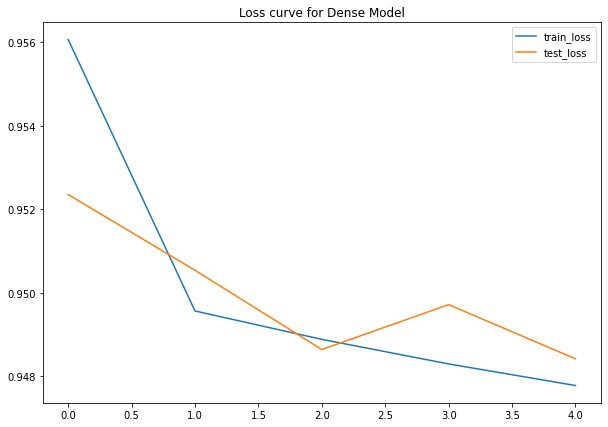

In [61]:
plt.figure(figsize=(10, 7))
plt.plot(history_2.history['loss'], label = 'train_loss')
plt.plot(history_2.history['val_loss'], label = 'test_loss')
plt.title("Loss curve for Dense Model")
plt.legend()
plt.show();

## Model 3: Add outputs of model 1 and 2 (MF and Dense)

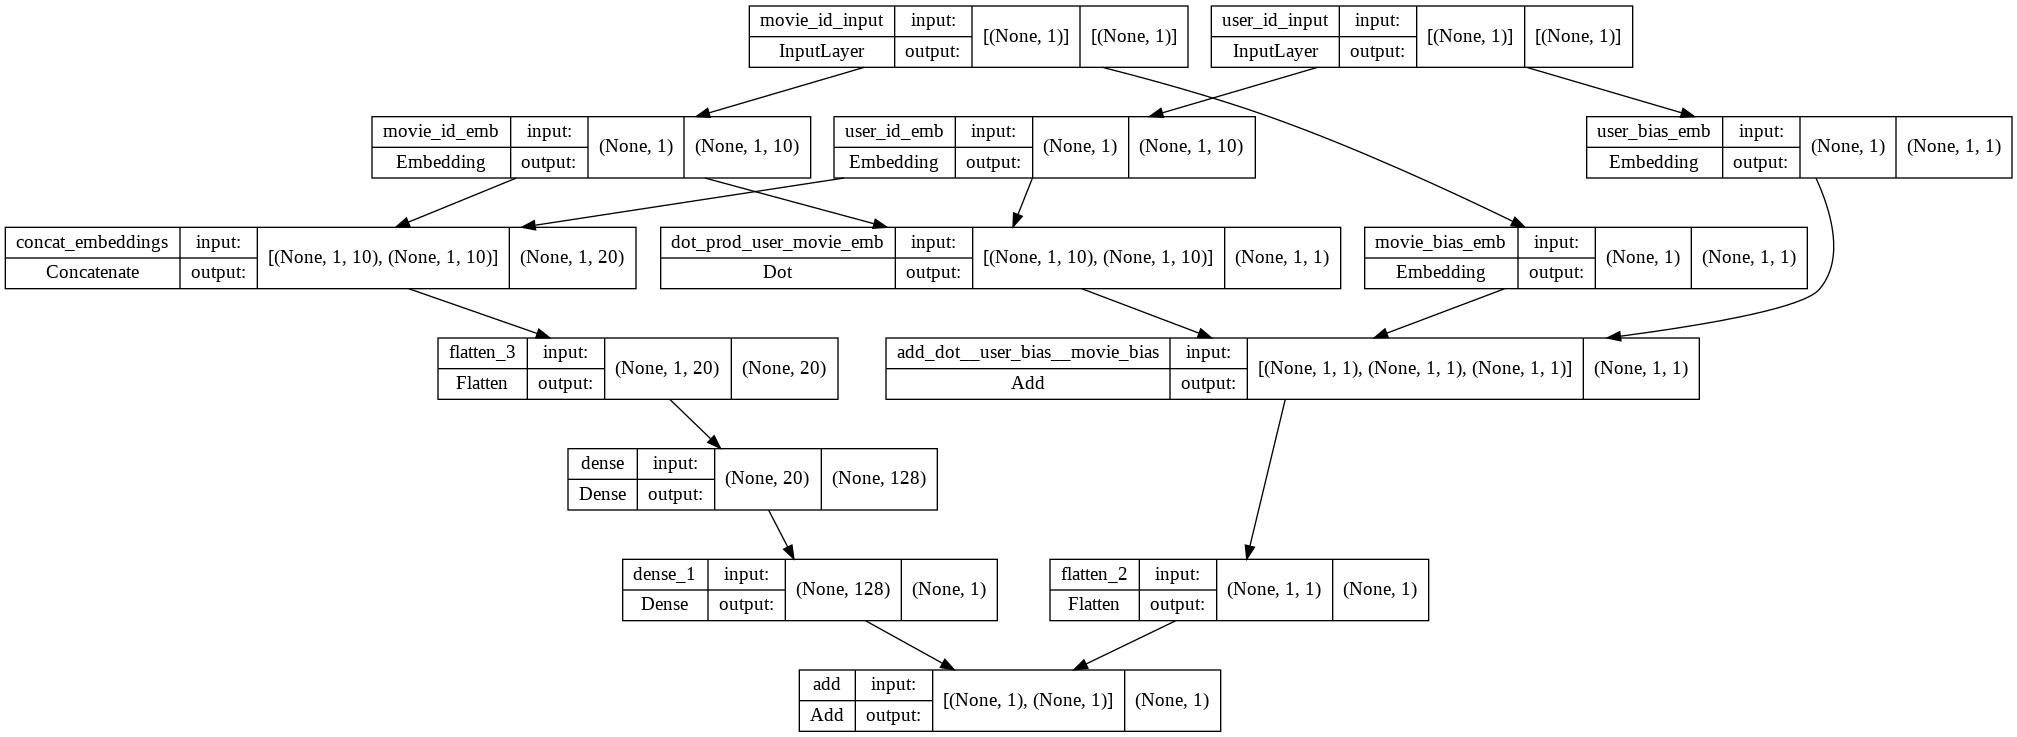

In [62]:
from numpy.ma.core import empty
u = Input(shape = (1,), name = "user_id_input")
m = Input(shape = (1,), name = "movie_id_input")

emb_u = Embedding(input_dim = N,
                  output_dim = K,
                  embeddings_regularizer = L2(l2=REG),
                  name = "user_id_emb")(u)

emb_m = Embedding(input_dim = M,
                  output_dim = K,
                  embeddings_regularizer = L2(l2=REG),
                  name = "movie_id_emb")(m)

## MF branch
user_bias_emb = Embedding(input_dim = N,
                          output_dim = 1,
                          embeddings_regularizer = L2(l2=REG),
                          name = "user_bias_emb")(u)

movie_bias_emb = Embedding(input_dim = M,
                           output_dim = 1,
                           embeddings_regularizer = L2(l2=REG),
                           name = "movie_bias_emb")(m)

x = Dot(axes=2, name = "dot_prod_user_movie_emb")([emb_u, emb_m])
x = Add(name = "add_dot__user_bias__movie_bias")([x, user_bias_emb, movie_bias_emb])
y1 = Flatten()(x)

## Deep NN branch
con = Concatenate(name = "concat_embeddings")([emb_u, emb_m])
x = Flatten()(con)
x = Dense(128, activation = 'relu')(x)
y2 = Dense(1, activation = None)(x)

y = Add()([y1, y2])

model_3 = tf.keras.Model(inputs = [u, m],
                         outputs = y, 
                         name = "model_3_add_op_model1_2")

tf.keras.utils.plot_model(model_3, show_shapes = True)

In [63]:
model_3.summary()

Model: "model_3_add_op_model1_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_id_input (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 movie_id_input (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 user_id_emb (Embedding)        (None, 1, 10)        10000       ['user_id_input[0][0]']          
                                                                                                  
 movie_id_emb (Embedding)       (None, 1, 10)        2000        ['movie_id_input[0][0]']         
                                                                            

In [ ]:
model_3.compile(
    loss = 'mse',
    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9),
    metrics = ['mse']
)

history_3 = model_3.fit(
    x = [df_train.userId.values, df_train.movie_idx.values],
    y = df_train.rating.values - mu,
    epochs = EPOCHS,
    batch_size = 128,
    validation_data = (
        [df_test.userId.values, df_test.movie_idx.values],
        df_test.rating.values - mu
    )
)

Epoch 1/5
27154/33701 [=======================>......] - ETA: 19s - loss: 0.9569 - mse: 0.9569